In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import setup
import parse
import utils
import train

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping
from sklearn.model_selection import train_test_split, KFold

#### Load original dataset and plot score distribution

In [ ]:
df = pd.read_csv(setup.DATASET_DIR+setup.DATASET_REGULAR, nrows=setup.N_ROWS*setup.DATASET_REGULAR_SIZE, dtype={"Fen": np.string_, "Evaluation": np.string_})
df["Evaluation"] = df["Evaluation"].apply(lambda x: parse.stockfish_eval_to_int(x))
df["Evaluation"].plot.hist(bins=100)

#### Random

In [ ]:
df_random = pd.read_csv(setup.DATASET_DIR+setup.DATASET_RANDOM, nrows=setup.N_ROWS*setup.DATASET_RANDOM_SIZE, dtype={"Fen": np.string_, "Evaluation": np.string_})
df_random["Evaluation"] = df_random["Evaluation"].apply(lambda x: parse.stockfish_eval_to_int(x))
df_random["Evaluation"].plot.hist(bins=100)

#### Tactics

In [ ]:
df_tactic = pd.read_csv(setup.DATASET_DIR+setup.DATASET_TACTIC, nrows=setup.N_ROWS*setup.DATASET_TACTIC_SIZE, dtype={"Fen": np.string_, "Evaluation": np.string_}, usecols=[0, 1])
df_tactic["Evaluation"] = df_tactic["Evaluation"].apply(lambda x: parse.stockfish_eval_to_int(x))
df_tactic["Evaluation"].plot.hist(bins=100)

#### Total dataset

In [ ]:
pd.concat([df, df_random, df_tactic])["Evaluation"].plot.hist(bins=100)

In [ ]:
del df, df_random, df_tactic

#### Load vectorized dataset and plot normalized score

In [2]:
df_vectorized = pd.read_csv(setup.DATASET_DIR+setup.DATASET_VECTORIZED)

In [ ]:
df_vectorized["label"].plot.hist(bins=100)

In [ ]:
df_vectorized

In [ ]:
# Check for null values
assert df_vectorized[df_vectorized.isnull().values].empty
# Check shape (+1 is for the label)
assert df_vectorized.shape == (setup.N_ROWS_EFFECTIVE, setup.N_FEATURES + 1)

### Train the model

In [ ]:
model, (history, train_error, cv_error, cv_error_normalized) = train.create_model_and_train(df_vectorized)

### Evaluate error and plot learning curve

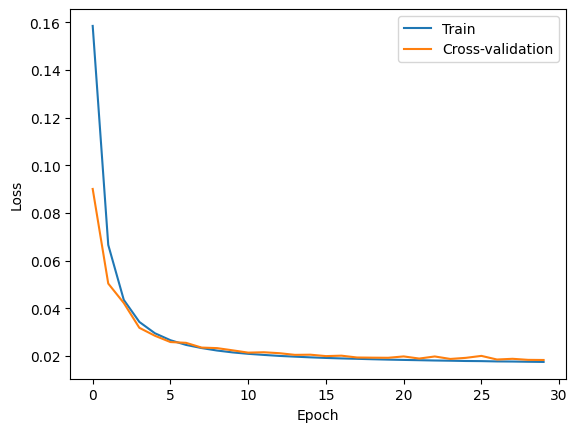

Training set error: 0.017
Cross-validation set error: 0.018
Cross-validation Normalized set error: 1600.85
Random classifier error: 0.11


In [4]:
utils.plot_learning_curve(history)
y_cv = df_vectorized["label"]

print(f"Training set error: {train_error:.2}")
print(f"Cross-validation set error: {cv_error:.2}")
print(f"Cross-validation Normalized set error: {cv_error_normalized:.6}")
print(f"Random classifier error: {((np.random.rand(len(y_cv)) - y_cv)**2).mean():.2}")

In [ ]:
if setup.SAVE_MODEL:
    model.save(setup.MODEL_NAME)

In [ ]:
if setup.K_FOLD:
    features = [f"f_{str(x)}" for x in range(1, setup.N_FEATURES+1)]
    k_fold = KFold(n_splits=setup.N_FOLDS)
    train_error_all = []
    cv_error_all = []
    X = df_vectorized[features]
    y = df_vectorized["label"]

    # TODO reset index first?
    for i, (train, test) in enumerate(k_fold.split(X, y)):
        model = create_model()
        _, train_error, cv_error = train_evaluate_model(model, X.loc[train], y.loc[train], X.loc[test], y.loc[test])
        train_error_all.append(train_error)
        cv_error_all.append(cv_error)
        print(f"Model #{i+1} done! CV error: {cv_error:.2}")
        del model

    print(f"Training sets error:{train_error_all}")
    print(f"Cross-validation sets sets errors:{cv_error_all}")
    print(f"Training sets mean error: {np.mean(np.array(train_error_all)):.2}")
    print(f"Cross-validation sets mean error: {np.mean(np.array(cv_error_all)):.2}")